### Imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"]="1"
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import toml
from time import time
import segmentation_models_pytorch as smp
from torchvision.transforms.transforms import RandomApply, GaussianBlur, ColorJitter

from src.data_utils import GaussianNoise
from src.color_conversion import Rgb2Hed, Hed2Rgb, LinearContrast
from src.embedding_loss import SpatialEmbLoss
from src.unet import UNet
from src.multi_head_unet import UnetDecoder, MultiHeadModel
from src.spatial_augmenter import SpatialAugmenter
from src.train_utils import instance_seg_train_step, instance_seg_validation, save_snapshot, save_model, make_cpvs
from src.data_utils import SliceDataset, CropDataset, H5pyDataset, add_3c_gt, center_crop
from src.cluster import Cluster

### Helper functions

In [2]:
def color_augmentations(size, s=0.5):
    # taken from https://github.com/sthalles/SimCLR/blob/master/data_aug/contrastive_learning_dataset.py
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = ColorJitter(0.8 * s, 0.0 * s, 0.8 * s, 0.2 * s) # brightness, contrast, saturation, hue
    HED_contrast = torch.nn.Sequential(
                Rgb2Hed(),
                LinearContrast(alpha=(0.75,1.25)),
                Hed2Rgb())
    data_transforms = torch.nn.Sequential(
        RandomApply([
            HED_contrast,
            color_jitter,
            GaussianNoise(0.005),
            GaussianBlur(kernel_size=3, sigma=(0.1,0.1))], p=0.5),
        )
    return data_transforms


def supervised_training(params, step, labeled_dataloader, fast_aug,  color_aug_fn,
                                                                inst_loss_fn,
                                                                writer,
                                                                device):
    # step = -1, step = 21000
    while step < params['training_steps']:
        print("Started training step %d" % step)
        tmp_loader = iter(labeled_dataloader)
        for raw, gt in tmp_loader:
            step += 1
            optimizer.zero_grad()
            loss, pred_inst, img_caug, gt_inst = instance_seg_train_step(model,
                                                                raw,
                                                                gt,
                                                                fast_aug,
                                                                color_aug_fn,
                                                                inst_loss_fn,
                                                                writer,
                                                                device,
                                                                step,
                                                                inst_model=params['instance_seg'])
            if torch.isnan(loss) or not torch.isfinite(loss):
                continue
            loss.backward()
            optimizer.step()
            #lr_scheduler.step()
            if step % params['validation_step'] == 0:
                val_new = instance_seg_validation(model,
                        validation_dataloader,
                        inst_loss_fn,
                        device,
                        step,
                        writer,
                        inst_model=params['instance_seg'])
                validation_loss.append(val_new)
                if val_new <= np.min(validation_loss):
                    print('Save best model')
                    save_model(step, model, optimizer, loss, os.path.join(log_dir,"best_model"))
            #
            if step % params['snapshot_step'] == 0:
                print('Save snapshot')
                tmp_dic = {
                        'img_caug': img_caug[0].squeeze(0).cpu().detach().numpy(),
                        'gt_inst': gt_inst.squeeze(0).cpu().detach().numpy()[:1]}
                if params['instance_seg'] == 'embedding':
                    _,_,h,w = pred_inst.shape
                    xym_s = inst_loss_fn.xym[:, 0:h, 0:w].contiguous()
                    spatial_emb = pred_inst[0, 0:2] + xym_s  # 2 x h x w
                    sigma = pred_inst[0, 2:2+inst_loss_fn.n_sigma]  # n_sigma x h x w
                    seed_map = torch.sigmoid(
                        pred_inst[0, 2+inst_loss_fn.n_sigma:2+inst_loss_fn.n_sigma + 1])  # 1 x h x w
                    tmp_dic['embedding'] = spatial_emb.cpu().detach().numpy()
                    tmp_dic['sigma'] = sigma.cpu().detach().numpy()
                    tmp_dic['seed_map'] = seed_map.cpu().detach().numpy()
                elif params['instance_seg'] == 'cpv_3c':
                    tmp_dic['pred_cpv'] = pred_inst[0,:2].cpu().detach().numpy()
                    tmp_dic['pred_3c'] = pred_inst[0,2:].softmax(0).cpu().detach().numpy()
                save_snapshot(snap_dir, tmp_dic, step)
            if step % params['checkpoint_step'] == 0:
                save_model(step, model, optimizer, loss, os.path.join(log_dir,"checkpoint_step_"+str(step)))

def cvp_loss_fn(input, gt_inst, divider):
    # diver = 155.0, divider = 256.0
    gt_inst = gt_inst.squeeze(0)
    gt_cpv_list = []
    for b in range(gt_inst.shape[0]):
        gt_cpv_list.append(make_cpvs(gt_inst.to(device)[b], device))
    gt_cpv = torch.cat(gt_cpv_list, axis=0)/divider
    loss_cpv = F.mse_loss(input = input[:,:2].tanh(),target = gt_cpv.float())
    return loss_cpv

def instance_seg_train_step_caug_is_saug(model, raw, gt, fast_aug, color_aug_fn, inst_lossfn, writer, device, step, inst_model='cpv_3c'):
    raw = raw.to(device).float()
    raw = raw + raw.min() *-1
    raw /= raw.max()
    gt = gt.to(device).float()
    B,_,_,_ = raw.shape
    if inst_model == 'cpv_3c':
        gt_3c_list = []
    raw_list = []
    gt_inst_list = []
    for b in range(B):
        img = raw[b].permute(2,0,1).unsqueeze(0) # BHWC -> BCHW
        gt_ = gt[b].permute(2,0,1).unsqueeze(0) # BHW2 -> B2HW
        img_saug, gt_saug = fast_aug.forward_transform(img, gt_)
        #gt_inst = fix_mirror_padding(gt_saug[0,0].cpu().detach().numpy().astype(np.int32)) # slow af
        #gt_inst = torch.tensor(gt_inst, device=device).float().unsqueeze(0)
        gt_inst = gt_saug[:,0]
        if inst_model == 'cpv_3c':
            gt_3c = gt_saug[:,2]
            gt_3c_list.append(gt_3c)
        img_caug = img_saug
        raw_list.append(img_caug)
        gt_inst_list.append(gt_inst)
    img_caug = torch.cat(raw_list, axis = 0)
    gt_inst  = torch.cat(gt_inst_list, axis = 0)
    out_fast = model(img_caug)
    _,_,H,W = out_fast.shape
    gt_inst = center_crop(gt_inst.unsqueeze(0), H, W)
    pred_inst = out_fast
    if inst_model == 'cpv_3c':
        gt_3c = torch.cat(gt_3c_list, axis = 0)
        gt_3c = center_crop(gt_3c.unsqueeze(0), H, W)
        instance_loss = inst_lossfn(pred_inst, gt_inst, gt_3c)
    else:
        instance_loss = inst_lossfn(pred_inst, gt_inst.squeeze(0).float(), (gt_inst.squeeze(0)>0).float())
    writer.add_scalar('instance_loss', instance_loss, step)
    print('loss', instance_loss.item())
    return instance_loss, pred_inst,img_caug, gt_inst

### Set parameters

In [3]:
torch.backends.cudnn.benchmark = True

torch.manual_seed(42)

params = {
    'data_path': '/home/julia/AG Kainmüller/Alzheimer_Segmentation_Annotation/tau_nerve_segmentation/data/data/cells',
    # directory name of report
    'experiment' : 'instance_seg_cell_bodies',
    'batch_size': 1,
    'training_steps': 2, #:400000,
    'in_channels': 3,
    'num_fmaps': 32,
    'fmap_inc_factors': 2,
    'downsample_factors': [ [ 2, 2,], [ 2, 2,], [ 2, 2,], [ 2, 2,],],
    'num_fmaps_out': 2,
    'constant_upsample': False,
    'padding': 'same',
    'activation': 'ReLU',
    'weight_decay': 1e-5,
    'learning_rate': 3e-4,
    'seed': 42,
    'num_validation': 15,
    'checkpoint_path': None, # 'exp_0_dsb/best_model',
    'pretrained_model': False,
    'multi_head': False,
    'uniform_class_sampling': False,
    'optimizer': 'AdamW', # one of SGD AdamW AdaBound , Adahessian breaks memory and is not supported
    'validation_step' : 10, #500,
    'snapshot_step' : 10, #5000,
    'checkpoint_step': 50, #20000,
    'instance_seg': 'embedding', # 'embedding' or 'cpv_3c'
    'attention': True,
    'color_augmentation_s': 0.4,
    'to_center': True
    }

# augmentation parameters
aug_params_fast = {}
"""

    'mirror': {'prob_x': 0.5, 'prob_y': 0.5, 'prob': 0.5},
    'translate': {'max_percent':0.05, 'prob': 0.2},
    'scale': {'min': 0.8, 'max':1.2, 'prob': 0.2},
    'zoom': {'min': 0.8, 'max':1.2, 'prob': 0.2},
    'rotate': {'max_degree': 179, 'prob': 0.75},
    'shear': {'max_percent': 0.1, 'prob': 0.2},
    'elastic': {'alpha': [120,120], 'sigma': 8, 'prob': 0.5}
}"""
print("parameters set")

# set directories for report
log_dir = os.path.join(params['experiment'],'train')
snap_dir = os.path.join(log_dir,'snaps')
os.makedirs(snap_dir, exist_ok=True)
writer_dir = os.path.join(log_dir,'summary', str(time()))
os.makedirs(writer_dir, exist_ok=True)
writer = SummaryWriter(writer_dir)
print("directories set")

# set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
params['device'] = device
params['aug_params_fast'] = aug_params_fast
with open(os.path.join(params['experiment'], 'params.toml'), 'w') as f:
    toml.dump(params, f)

parameters set


2022-12-08 14:39:07.416338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 14:39:09.895149: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/julia/.local/share/virtualenvs/tau_nerve_segmentation-s0uDq-Et/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-08 14:39:09.895246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/julia/.loc

directories set
cpu


### Load data

In [4]:
file_paths = [os.path.join(params['data_path'], file) for file in os.listdir(params['data_path'])]
random.Random(params['seed']).shuffle(file_paths)
val_paths = [file_paths.pop(0) for _ in range(params['num_validation'])]
labeled_paths = file_paths
labeled_dataset = H5pyDataset(labeled_paths, raw_keys=['raw'], label_keys=['gt_instances'], crop_size=(1200, 1312))
validation_dataset = H5pyDataset(val_paths, raw_keys=['raw'], label_keys=['gt_instances'], crop_size=(1200, 1312))

labeled_dataloader = DataLoader(labeled_dataset,
                        batch_size=params['batch_size'],
                        shuffle=True,
                        prefetch_factor=4,
                        num_workers=4)

validation_dataloader = DataLoader(validation_dataset,
                    batch_size=1,
                    shuffle=True,
                    prefetch_factor=4,
                    num_workers=1)

In [5]:
dataiter = iter(labeled_dataloader)
# repeatedly execute this cell
image, label = next(dataiter)
print(label.shape)

RuntimeError: DataLoader worker (pid(s) 8756) exited unexpectedly

### Select model

In [6]:
if params['pretrained_model']:
    if params['multi_head']:
        encoder = smp.encoders.get_encoder(
            name= "timm-efficientnet-b5",
            in_channels=3,
            depth=5,
            weights="imagenet").to(device)
        decoder_channels = (256, 128, 64, 32, 16)
        decoder_inst = UnetDecoder(
                    encoder_channels=encoder.out_channels,
                    decoder_channels=decoder_channels,
                    n_blocks=5,
                    use_batchnorm=True,
                    center=False,
                    attention_type='scse' if params['attention'] else None
                    ).to(device)
        decoder_ct = UnetDecoder(
                    encoder_channels=encoder.out_channels,
                    decoder_channels=decoder_channels,
                    n_blocks=5,
                    use_batchnorm=True,
                    center=False,
                    attention_type='scse' if params['attention'] else None
                    ).to(device)
        head_inst = smp.base.SegmentationHead(
                    in_channels=decoder_channels[-1],
                    out_channels=5,
                    activation=None,
                    kernel_size=1).to(device)
        head_ct = smp.base.SegmentationHead(
                    in_channels=decoder_channels[-1],
                    out_channels=7,
                    activation=None,
                    kernel_size=1).to(device)

        decoders = [decoder_inst, decoder_ct]
        heads = [head_inst, head_ct]
        model = MultiHeadModel(encoder, decoders, heads)
    else:
        model = smp.Unet(
            encoder_name= "timm-efficientnet-b5", # "timm-efficientnet-b5", # choose encoder
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=params['num_fmaps_out'],                      # model output channels (number of classes in your dataset)
            decoder_attention_type='scse' if params['attention'] else None,
            ).to(params['device'])
#preprocess_input = smp.encoders.get_preprocessing_fn('efficientnet-b5', pretrained='imagenet')
else:
    model = UNet(in_channels = params['in_channels'],
                num_fmaps = params['num_fmaps'],
                fmap_inc_factor = params['fmap_inc_factors'],
                downsample_factors = params['downsample_factors'],
                activation = params['activation'],
                padding = params['padding'],
                num_fmaps_out = params['num_fmaps_out'],
                constant_upsample = params['constant_upsample'],
            ).to(params['device'])

if 'checkpoint_path' in params.keys() and params['checkpoint_path']:
    model.load_state_dict(torch.load(params['checkpoint_path'])['model_state_dict'])
model = model.train()

In [7]:
from torchsummary import summary
summary(model, (3, 1200, 1312))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1200, 1312]             896
              ReLU-2       [-1, 32, 1200, 1312]               0
            Conv2d-3       [-1, 32, 1200, 1312]           9,248
              ReLU-4       [-1, 32, 1200, 1312]               0
          ConvPass-5       [-1, 32, 1200, 1312]               0
         MaxPool2d-6         [-1, 32, 600, 656]               0
        Downsample-7         [-1, 32, 600, 656]               0
            Conv2d-8         [-1, 64, 600, 656]          18,496
              ReLU-9         [-1, 64, 600, 656]               0
           Conv2d-10         [-1, 64, 600, 656]          36,928
             ReLU-11         [-1, 64, 600, 656]               0
         ConvPass-12         [-1, 64, 600, 656]               0
        MaxPool2d-13         [-1, 64, 300, 328]               0
       Downsample-14         [-1, 64, 3

### Initialize optimizer, augmentations and summary writer

In [8]:
# Optimizer
if params['optimizer'] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=params['learning_rate'],
                                momentum=0.9,
                                weight_decay=params['weight_decay'],
                                nesterov=True)
elif params['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=params['learning_rate'],
                                  weight_decay=params['weight_decay'])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['training_steps'], eta_min=5e-6)

# Augmentation
fast_aug = SpatialAugmenter(aug_params_fast)#, padding_mode='reflection')
if params['instance_seg'] == 'embedding':
    inst_loss_fn = SpatialEmbLoss(n_sigma=2, to_center=params['to_center'], foreground_weight=10, H=1197, W=1299).to(device)
elif params['instance_seg'] == 'cpv_3c':
    def inst_loss_fn(input, gt_inst, gt_3c):
        gt_cpv_list = []
        gt_inst = gt_inst.squeeze(0)
        for b in range(gt_inst.shape[0]):
            gt_cpv_list.append(make_cpvs(gt_inst.to(device)[b], device))
        gt_cpv = torch.cat(gt_cpv_list, axis=0)
        loss_cpv = F.mse_loss(input = input[:,:2],target = gt_cpv.float())
        loss_3c =  F.cross_entropy(input = input[:,2:],
                        target = gt_3c.long().squeeze(0).to(device),
                        weight=torch.tensor([1,1,2]).float().to(device))
        return loss_cpv + loss_3c


color_aug_fn = color_augmentations(200, s=params['color_augmentation_s'])
validation_loss = []
step = -1

Created spatial emb loss function with: to_center: True, n_sigma: 2, foreground_weight: 10


### Set cluster

In [14]:
cl = Cluster(grid_y=1197, grid_x=1299, pixel_y=1, pixel_x=1)

#inst_loss_fn = SpatialEmbLoss(n_sigma=2, to_center=params['to_center'], foreground_weight=3, H=256,W=256).to(device)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### Train

In [9]:
supervised_training(params, -1, labeled_dataloader, fast_aug, color_aug_fn, inst_loss_fn, writer, device)

Started training step -1
step started
finished aug
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769],
          [0.0000, 0.0000, 0.0000,  ..., 0.0769, 0.0769, 

RuntimeError: Can not downsample shape torch.Size([1, 32, 1197, 1299]) with factor [2, 2], mismatch in spatial dimension 1

'\narray_list = []\nfor file in files:\n    image = np.load(file)\n    array_list.append(image)\nnp.concatenate(array_list, axis=0 )\nprint(array_list)'

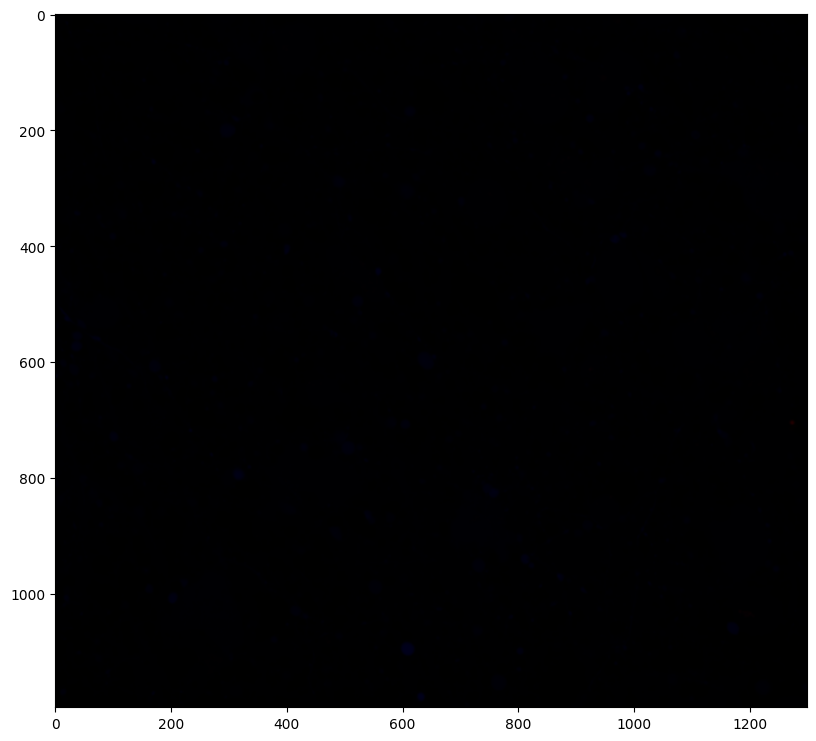

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
path = '/home/julia/AG Kainmüller/Alzheimer_Segmentation_Annotation/tau_nerve_segmentation/data/data/cells'
files = [os.path.join(path, file) for file in os.listdir(path)]
fig=plt.figure(figsize=(12, 9))
fig.add_subplot(1, 1, 1)
plt.imshow(np.squeeze(h5py.File(files[15], "r")["raw"]))
"""
array_list = []
for file in files:
    image = np.load(file)
    array_list.append(image)
np.concatenate(array_list, axis=0 )
print(array_list)"""

In [13]:

os.getcwd()

'/home/julia/AG Kainmüller/Alzheimer_Segmentation_Annotation/tau_nerve_segmentation/segmentation_pipeline'

In [6]:
from PIL import Image
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

path = '/home/julia/AG Kainmüller/Alzheimer_Segmentation_Annotation/tau_nerve_segmentation/data/data/cells'
raw_path = '/home/julia/AG Kainmüller/Alzheimer_Segmentation_Annotation/tau_nerve_segmentation/data/share_data'
def rebuild_hp5(file_path, raw_path):
    raw_folders = [(os.path.join(raw_path, fol), fol) for fol in os.listdir(raw_path)]
    raw_folders.pop(5)
    for folder, folder_name in raw_folders:
        files = [os.path.join(folder + "/blue_channel" , file) for file in os.listdir(folder + "/blue_channel")]
        for file in files:
            if ".tif" in file:
                file_name = file[len(file) - 10:len(file)-4]
                if file_name[0] == "/":
                    file_name = file_name[1:]
                h5_file = h5py.File(file_path + "/" + folder_name + "_" + file_name + ".hdf5", 'x')
                # add raws
                raw = np.array(Image.open(file))
                h5_file["raw"] = raw
                # add instances
                instances = np.array(Image.open(file_path + "_copy/label/" + folder_name + "_" + file_name + ".png"))
                h5_file["gt_instances"] = instances
                # add labels
                labels = instances.copy()
                labels[labels > 0] = 1
                h5_file["gt_labels"] = labels
                h5_file.close()

rebuild_hp5(path, raw_path)